# Experimentos Estatísticos e Teste de significância

O *design* de experimentos é um pilar fundamental da prática da estatística, com aplicações em praticamente todas as áreas de pesquisa. **O objetivo é projetar um experimento para confirmar ou rejeitar uma hipótese**. Cientistas de dados frequentemente precisam conduzir experimentos contínuos, especialmente em relação à interface do usuário e marketing de produtos. Este capítulo revisa o design experimental tradicional e discute alguns desafios comuns na ciência de dados. Também aborda alguns conceitos frequentemente citados em inferência estatística e explica seu significado e relevância (ou falta de relevância) para a ciência de dados.

Sempre que vê-se referências a significância estatística, **testes-t** ou ***p-values***, geralmente é no contexto do “*pipeline*” clássico de inferência estatística. Este processo começa com uma hipótese (“o medicamento A é melhor do que o medicamento padrão existente” ou “o preço A é mais lucrativo do que o preço B existente”). Um experimento (que pode ser um teste A/B) é projetado para testar a hipótese, de forma que, idealmente, forneça resultados conclusivos. Os dados são coletados e analisados, e então uma conclusão é tirada. O termo inferência reflete a intenção de aplicar os resultados do experimento, que envolvem um conjunto limitado de dados, a um processo ou população maior.

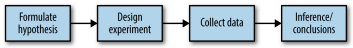

## Material:
* **Practical Statistics for Data Scientists** de *Peter Bruce*, *Andrew Bruce* & *Peter Gedeck*.

## Material de Apoio:
* **Statistical Inference** de *George Casella* & *Roger L. Berger*;
* **Probability and Statistics** de *Morris H. DeGroot* & *Mark j. Schervish*; e
* **Notas de aula do Curso de Inferência I** da *Disciplina Regular da UFRJ*.


In [16]:
# Bibliotecas Utilizadas:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [17]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [18]:
# Datasets:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

# Teste A/B

Um **teste A/B** é um experimento com dois grupos para determinar qual dos dois tratamentos, produtos, procedimentos ou similares é superior. Frequentemente, um dos dois tratamentos é o tratamento padrão existente ou nenhum tratamento. Se um tratamento padrão (ou nenhum) for usado, ele é chamado de **controle**. Uma hipótese típica é que um novo tratamento é melhor do que o controle.

In [19]:
# Simulando dados
np.random.seed(42)
data = {
    'group': np.random.choice(['A', 'B'], size=1000),
    'conversion': np.random.choice([0, 1], size=1000, p=[0.7, 0.3])
}

df = pd.DataFrame(data);df

,group,conversion
0,A,0
1,B,0
2,A,0
3,A,1
4,A,0
...,...,...
995,A,0
996,A,0
997,B,0
998,B,0


In [20]:
# Calculando a taxa de conversão para cada grupo
conversion_rates = df.groupby('group')['conversion'].mean()
print("Taxa de conversão por grupo:")
print(conversion_rates)

Taxa de conversão por grupo:
group
A    0.291837
B    0.298039
Name: conversion, dtype: float64


In [21]:
# Agrupando dados de cada grupo
group_a = df[df['group'] == 'A']['conversion']
group_b = df[df['group'] == 'B']['conversion']

# Realizando o teste t
t_stat, p_value = stats.ttest_ind(group_a, group_b)
print("Resultado do Teste T:")
print(f"t-statistic: {t_stat}, p-value: {p_value}")

Resultado do Teste T:
t-statistic: -0.2147921040856866, p-value: 0.8299732907388063


In [22]:
# Interpretando o resultado
alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula. Há uma diferença significativa entre os grupos.")
else:
    print("Não rejeitamos a hipótese nula. Não há diferença significativa entre os grupos.")

Não rejeitamos a hipótese nula. Não há diferença significativa entre os grupos.


**Ideias Principais:**

* Os sujeitos são designados a dois (ou mais) grupos que são tratados exatamente da mesma forma, exceto que o tratamento em estudo difere de um grupo para outro.

* Idealmente, os sujeitos são designados aleatoriamente aos grupos.

Ou seja, teste A/B é apenas um procedimento, procedimento cuja o qual compara dois tipos de abordagens diferentes. Poderia ser por mais procedimentos? Um teste A/B/C/D... etc? Poderia. A principal questão aqui é saber trabalhar com testes estatísticos, é isso que realmente importa aqui.

# Teste de Hipótese:

Suponha que $X_1, \ldots, X_n$ formem uma amostra aleatória de uma distribuição cuja função de densidade de probabilidade (p.d.f.) ou função de probabilidade (p.f.) é $f(x|\theta)$, onde o valor do parâmetro $\theta \in \Theta$; $\Theta_0$ e $\Theta_1$ são conjuntos disjuntos com $\Theta_0 \cup \Theta_1 = \Theta$. Deste modo, definimos o teste de hipotese como:

$$
\begin{align*}
H_0&: \theta \in \Theta_0 \\
H_1&: \theta \in \Theta_1 \\
\end{align*}$$

Onde,
* $H_0$ é a **hipótese nula**. Representa o “*status quo*” ou a ausência de efeito.
* $H_1$ é a **hipótese alternativa**. Representa a hipótese de pesquisa, indicando a presença de um efeito.

In [23]:
# Tamanho da amostra
n = 30

# Criando a sequência X_1, ..., X_n
X = np.random.normal(loc=0, scale=1, size=n);X

array([-2.49940571,  2.29094257, -1.38957247, -1.64539875,  1.02257043,
        2.43975241,  1.38427282,  0.56390912,  0.59475434,  0.85341556,
        0.75892859,  0.28119142,  0.1042011 , -0.06259313, -0.75396459,
       -0.28067508, -1.69295681, -0.09833963, -0.98859111, -1.10358932,
        0.17989415,  1.39200229,  0.91831661, -1.5705006 , -0.98962814,
        0.94077119, -0.98248739, -0.22463315,  0.5500521 , -0.96834445])

## Região crítica e estatísticas de teste

A região critica representa o conjunto de valores da estatística de teste que leva à rejeição da hipótese nula $H_0$. Em outras palavras, se a estatística de teste cair dentro da região crítica, concluímos que há evidências suficientes para rejeitar $H_0$ em favor da hipótese alternativa $H_1$.

A ideia do teste de hípose é calcular de distância entre duas medidas de probabilidade. Para isso, podemos pensar em escolher um número $c$ e rejeitar $H_0$ se a distância da **estatística de teste** ao **valor da hipótese nula** for **maior** que $c$. Uma maneira de expressar isso é dividindo o conjunto $S$ de todos os possíveis vetores de dados $x = (x_1, \ldots, x_n)$ (o espaço amostral) em dois conjuntos:

$$S_0 = \{x : -c \leq X_n - \mu_0 \leq c\}\ e\ S_1 = S_0^C$$

In [24]:
# Importando Função norm: 
from scipy.stats import norm # Esta função é capaz de retornar uma das sete normas matriciais diferentes, dependendo do valor do parâmetro ord.

In [25]:
# Definindo os parâmetros
mu_0 = 0  # Média sob a hipótese nula
sigma = 1  # Desvio padrão conhecido
alpha = 0.05  # Nível de significância

## Função Poder:

Deixe $\delta$ ser um procedimento de teste. A função $\pi(\theta|\delta)$ é chamada de **função poder** do teste $\delta$. Se $S_1$ denota a região crítica de $\delta$, então a função poder $\pi(\theta|\delta)$ é determinada pela relação 

$$\pi(\theta|\delta) = \Pr(X \in S_1|\theta) \text{ para } \theta \in \Theta$$

Como estamos no contexto normal, se $\delta$ é descrito em termos de uma estatística de teste $T$ e região de rejeição $R$, a função poder é
$$\pi(\theta|\delta) = \Pr(T \in R|\theta) \text{ para } \theta \in \Theta$$

Deste modo,

$$\begin{align*}
Pr(T \in R|\mu) &= Pr(\bar{X}_n\ge \mu_0 + c|\mu) + Pr(\bar{X}_n\le \mu_0)\\
&=1-\Phi\left(\sqrt{n}\frac{\mu_0+c-\mu}{\sigma}\right)+\Phi\left(\sqrt{n}\frac{\mu_0-c-\mu}{\sigma}\right)
\end{align*}
$$

In [26]:
# Calculando a média da amostra
X_n = np.mean(X)

# Calculando a estatística de teste
T = np.abs(X_n - mu_0) / (sigma / np.sqrt(n))

# Determinando o valor crítico para o nível de significância
c = norm.ppf(1 - alpha / 2)

# Verificando se rejeitamos a hipótese nula
if T >= c:
    print("Rejeitamos a hipótese nula (H0).")
else:
    print("Não rejeitamos a hipótese nula (H0).")

# Exibindo os resultados
print(f"Média da amostra (X_n): {X_n}")
print(f"Estatística de teste (T): {T}")
print(f"Valor crítico (c): {c}")

Não rejeitamos a hipótese nula (H0).
Média da amostra (X_n): -0.03252352093356799
Estatística de teste (T): 0.17813866064806666
Valor crítico (c): 1.959963984540054


# Reamostragem:

*Resampling*(reamostragem) em estatística significa amostrar repetidamente valores de dados observados, com o objetivo geral de avaliar a **variabilidade aleatória** em uma estatística. Também pode ser usado para avaliar e melhorar a precisão de alguns modelos de aprendizado de máquina (por exemplo, as previsões de modelos de árvore de decisão construídos em vários conjuntos de dados bootstrapped podem ser médias em um processo conhecido como bagging).

Existem dois tipos principais de procedimentos de reamostragem: o ***bootstrap*** e os **testes de permutação**. O *bootstrap* é usado para avaliar a confiabilidade de uma estimativa; e foi discutido em estúdo próprio. Os **testes de permutação** são usados para testar hipóteses, geralmente envolvendo dois ou mais grupos, e discutimos esses testes nesta seção.

## Permutation Test

Em um procedimento de **permutação**, duas ou mais amostras estão envolvidas, tipicamente os grupos em um teste de hipótese A/B ou outro. **Permutar significa mudar a ordem de um conjunto de valores**. O primeiro passo em um teste de permutação de uma hipótese é combinar os resultados dos grupos A e B (e, se usados, C, D, …). Esta é a incorporação lógica da hipótese nula de que os tratamentos aos quais os grupos foram expostos não diferem. Em seguida, testamos essa hipótese sorteando aleatoriamente grupos deste conjunto combinado e vendo o quanto eles diferem uns dos outros. O procedimento de permutação é o seguinte:

* Combine os resultados dos diferentes grupos em um único conjunto de dados.
* Embaralhe os dados combinados e, em seguida, sorteie aleatoriamente (sem reposição) uma reamostra do mesmo tamanho do grupo A (claramente conterá alguns dados dos outros grupos).
* Dos dados restantes, sorteie aleatoriamente (sem reposição) uma reamostra do mesmo tamanho do grupo B.
* Faça o mesmo para os grupos C, D, e assim por diante. Agora você coletou um conjunto de reamostras que espelham os tamanhos das amostras originais.
* Qualquer que seja a estatística ou estimativa calculada para as amostras originais (por exemplo, diferença nas proporções dos grupos), calcule-a agora para as reamostras e registre; isso constitui uma iteração de permutação.
* Repita os passos anteriores R vezes para obter uma distribuição de permutação da estatística do teste.
* Agora volte à diferença observada entre os grupos e compare-a com o conjunto de diferenças permutadas. Se a diferença observada estiver bem dentro do conjunto de diferenças permutadas, então não provamos nada—a diferença observada está dentro do intervalo que o acaso pode produzir. No entanto, se a diferença observada estiver fora da maior parte da distribuição de permutação, então concluímos que o acaso não é responsável. Em termos técnicos, a diferença é estatisticamente significativa. (Veja “Significância Estatística e Valores-p” na página 103).

In [31]:
# Instanciando conjunto de dados:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

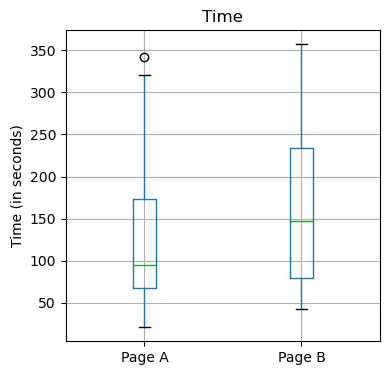

In [33]:
# Visualizando conjunto de dados:
ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [36]:
# Média das Páginas:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()

# Diferença das médias:
print(mean_b, mean_a)
print(mean_b - mean_a)

162.0 126.33333333333333
35.66666666666667


In [46]:
# Exemplo de teste de permutação com aderência
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

-20.447619047619042


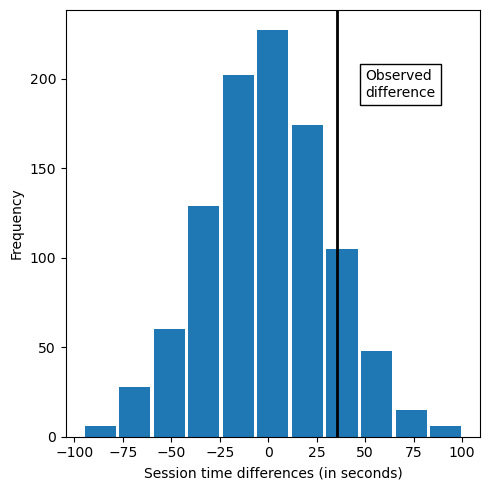

In [48]:
# Visualização:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [50]:
# converte perm_diffs em numpy array:
perm_diffs = np.array(perm_diffs)
print(np.mean(perm_diffs > mean_b - mean_a))

0.121
